<a href="https://colab.research.google.com/github/darthfelipe21/LangGraph/blob/main/LangGraphSupervisorAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervisor agents

The supervisor multi-agent architecture introduces the concept of a ***supervisor agent***; that is, an agent whose purpose is to delegate tasks to other agents and respond to the user input.

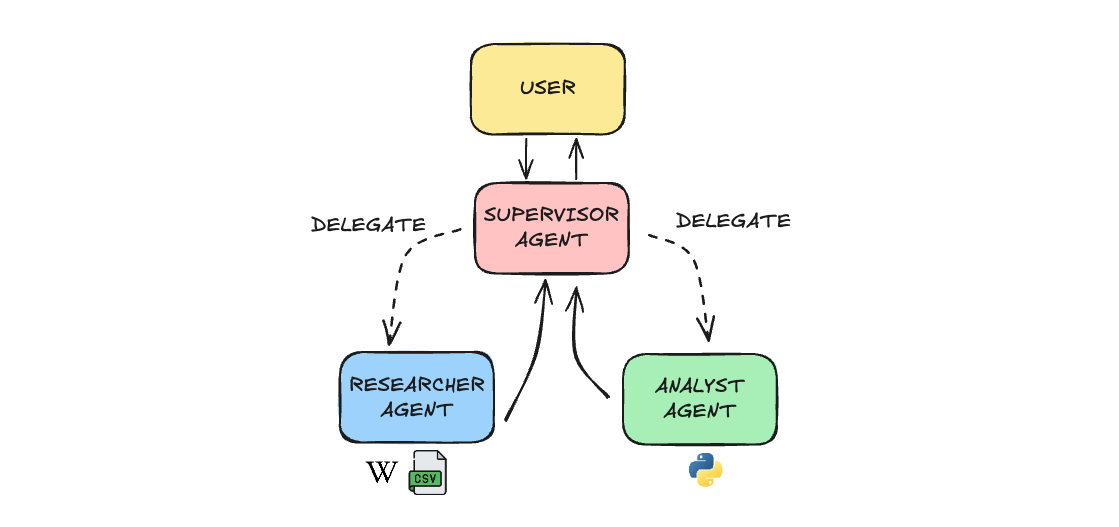

This requires a couple of updates to your current implementation:
1. Modification of the prompts used in the researcher and analyst worker agents, so they are able to collaborate effectively with the supervisor.
2. The creation of a supervisor agent node.

In [ ]:
!pip install --quiet wikipedia==1.4.0 langchain-core==0.3.69 langgraph==0.5.3 langchain-openai==0.3.28 langchain-experimental==0.3.4 langgraph-supervisor==0.0.27

In [ ]:
from typing import Annotated
import wikipedia
from langchain_core.tools import tool
import pandas as pd
import os

@tool
def wikipedia_tool(
    query: Annotated[str, "The Wikipedia search to execute to find key summary information."],
):
    """Use this to search Wikipedia for factual information."""
    try:
        # Step 1: Search using query
        results = wikipedia.search(query)

        if not results:
            return "No results found on Wikipedia."

        # Step 2: Retrieve page title
        title = results[0]

        # Step 3: Fetch summary
        summary = wikipedia.summary(title, sentences=8, auto_suggest=False, redirect=True)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\nWikipedia summary: {summary}"

@tool
def stock_data_tool(
    company_ticker: Annotated[str, "The ticker symbol of the company to retrieve their stock performance data."],
    num_days: Annotated[int, "The number of business days of stock data required to respond to the user query."]
) -> str:
    """
    Use this to look-up stock performance data for companies to retrieve a table from a CSV. You may need to convert company names into ticker symbols to call this function, e.g, Apple Inc. -> AAPL, and you may need to convert weeks, months, and years, into days.
    """

    # Load the CSV for the company requested
    file_path = f"data/{company_ticker}.csv"

    if os.path.exists(file_path) is False:
        return f"Sorry, but data for company {company_ticker} is not available. Please try Apple, Amazon, Meta, Microsoft, Netflix, or Tesla."

    stock_df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

    # Ensure the index is in date format
    stock_df.index = stock_df.index.date

    # Maximum num_days supported by the dataset
    max_num_days = (stock_df.index.max() - stock_df.index.min()).days

    if num_days > max_num_days:
        return "Sorry, but this time period exceeds the data available. Please reduce it to continue."

    # Get the most recent date in the DataFrame
    final_date = stock_df.index.max()

    # Filter the DataFrame to get the last num_days of stock data
    filtered_df = stock_df[stock_df.index > (final_date - pd.Timedelta(days=num_days))]

    return f"Successfully executed the stock performance data retrieval tool to retrieve the last *{num_days} days* of data for company **{company_ticker}**:\n\n{filtered_df.to_markdown()}"

from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. The chart should be displayed using `plt.show()`."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed the Python REPL tool.\n\nPython code executed:\n\`\`\`python\n{code}\n\`\`\`\n\nCode output:\n\`\`\`\n{result}\`\`\`"

### 🔧 Modifying the worker agent prompts

Let's first modify these agent prompts to provide specific instructions on how to work with the supervisor agent.

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o-mini")

# Research agent
research_agent = create_react_agent(
    llm,
    tools=[wikipedia_tool, stock_data_tool],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, including looking-up factual information and stock data. DO NOT write any code.\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="researcher"
)

# Analyst agent
analyst_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=(
        "You are an agent that can run arbitrary Python code.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with tasks that require running code to produce an output.\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="analyst"
)

### 📋 Defining the supervisor agent

With the `"researcher"` and `"analyst"` tools defined, it's time to define the supervisor agent.

LangGraph provides the `langgraph-supervisor` library, which provides some useful abstractions to streamline the creation of supervisor multi-agent systems, and we'll be using that here.

If, instead, you'd prefer to stick to lower-level, core LangGraph code, check out [this implementation](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#3-create-supervisor-from-scratch) in the LangGraph documentation.

The `create_supervisor()` function from `langgraph-supervisor` is analogous to the `create_react_agent()` in `langgraph.prebuilt`. It provides a ready-made class that only requires the agents to manage, an LLM for the generating the text required for supervising the agents and responding to the user, and a `prompt` for dictating how to operate. Everything else, including a mechanism for building a conversation history, a function for deciding when to delegate a task, and more, are already coded into this class.

`create_supervisor()` supports many parameters to modify its default behavior, but we'll only use two here:
1. `add_handoff_back_messages`: additional messages indicating when a worker agent hands the task back to the supervisor.
2. `output_mode`: controls how messages from worker agents are added to the conversation history of the system.

In [ ]:
from langgraph_supervisor import create_supervisor
from langgraph.checkpoint.memory import InMemorySaver

config = {"configurable": {"thread_id": "1", "user_id": "1"}}
checkpointer = InMemorySaver()

supervisor = create_supervisor(
    model=llm,
    agents=[research_agent, analyst_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research and data collection tasks to this agent\n"
        "- an analyst agent. Assign the creation of visualizations via code to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile(checkpointer=checkpointer)

### 👔 Visualizing the supervisor

Run the visualization code one final time to see the updated graph!

In [ ]:
# Visualize your graph
supervisor

### 🧪 Testing user inputs

Time to call the supervisor agent to test out how it performs!
- Who is Apple's CEO?
- Has Tesla's share price increased over the last month?

We've used a helper function here to generate nicely-formatted outputs, but omitted it from this notebook due to its length. However, you can view it by opening the `course_helper_functions.py` file.

In [ ]:
from course_helper_functions import pretty_print_messages

for chunk in supervisor.stream(
    {"messages": [{"role": "user", "content": "Who is Apple's CEO?"}]}, config
):
    pretty_print_messages(chunk)

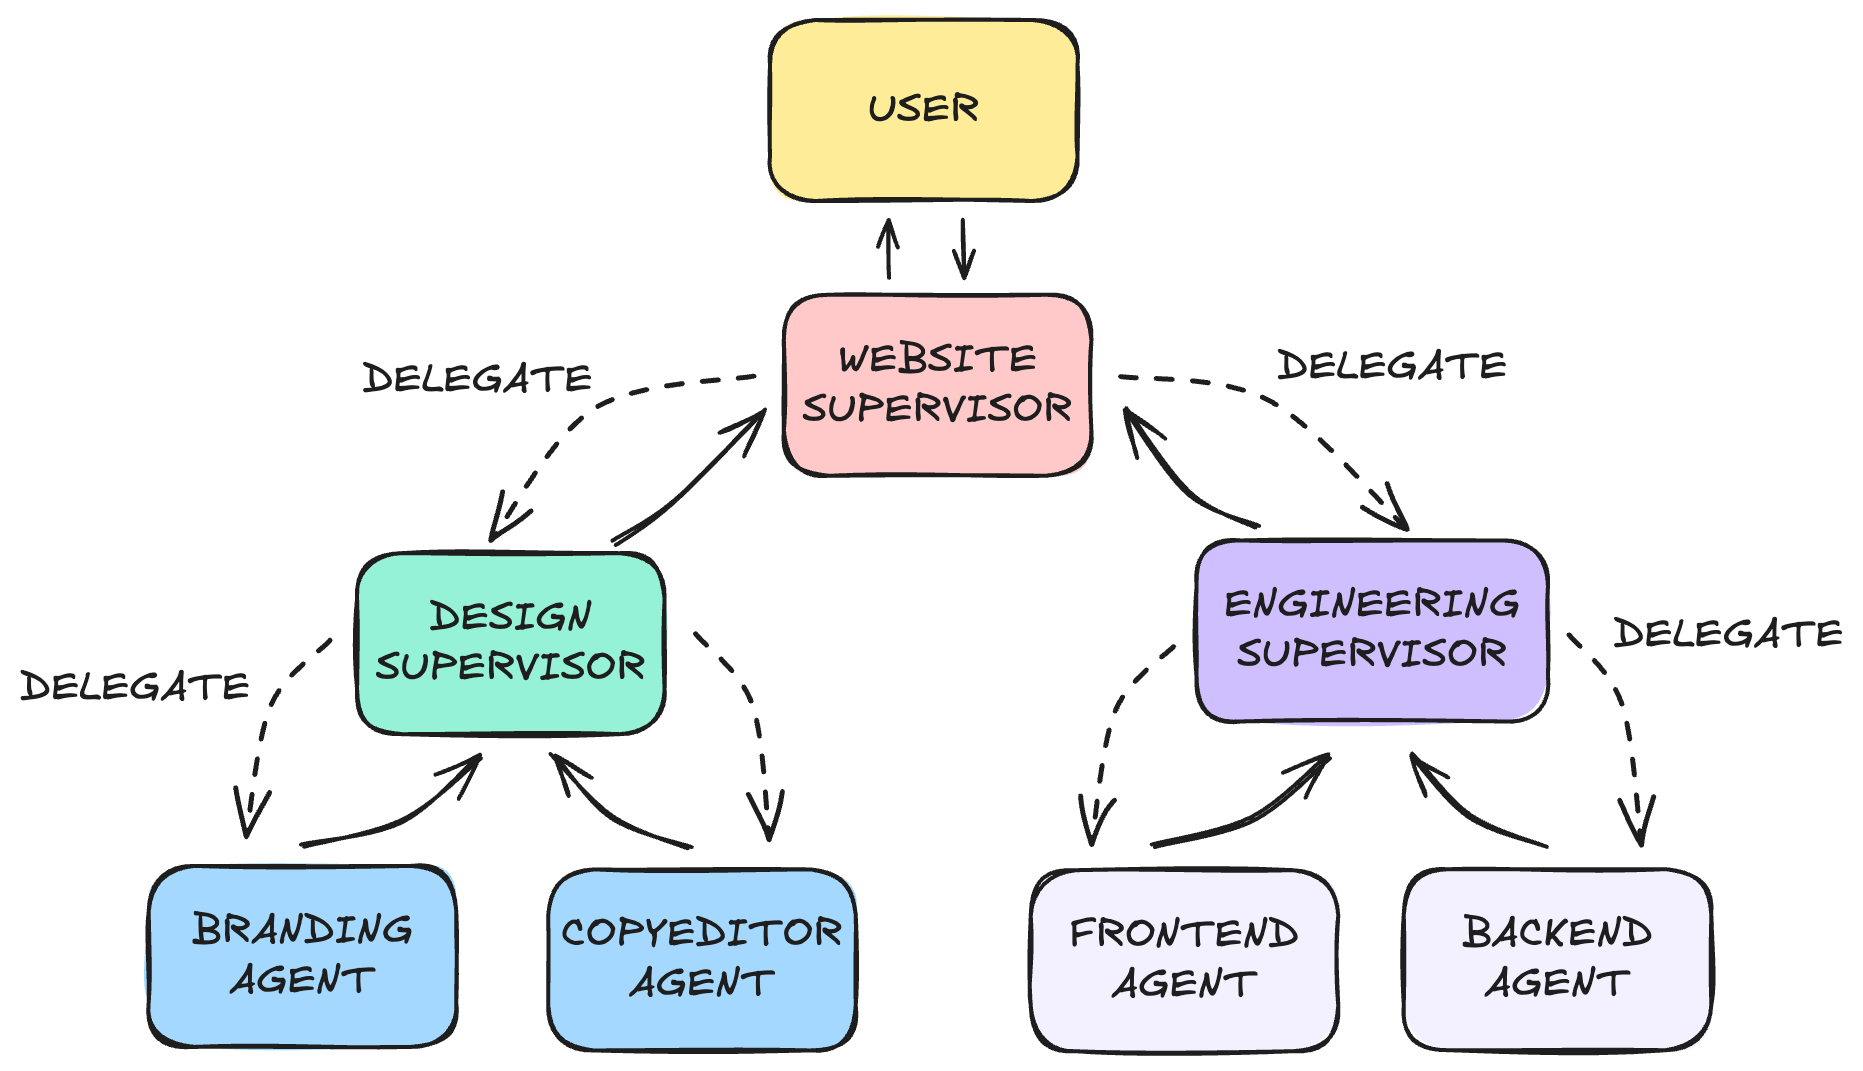

### 🧠 Some thoughts to finish on

- **There's no once-size-fits-all approach to building multi-agent systems**: the best system design is highly use case-dependent, so study the needs closely, build, and test!
- **Prompts are very important**: you may have seen while experimenting in this course, that you can connect all of the pieces together correctly, and still not get a performant system. Clear, instructive prompts are paramount for the agents to "understand" how to go about their tasks and collaborate with one another.
- **LangGraph abstractions are there if you need them**: LangGraph prides itself on providing a low-level syntax, which gives more customizability than to about any other framework. Such low-level syntax isn't for the faint-hearted, so don't be afraid to lean on some of the pre-built functionality when you're building a first-attempt project&mdash;you can always reconfigure it during the experimentation phase if the need is there.